## Trabajo Práctico N°3

*Introducción*

Construcción de un clasificador utilizando los algoritmos de:
1. KNN y GridSearch
2. Regresión logística y GridSearch
3. Arboles

En sus distintas versiones y comparar resultados. El DataSet será el propuesto por el grupo


## Inicio
**Importación de librerías**<br>

In [1]:
#Importo las librerias que deseo usar
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns ; sns.set(color_codes=True)
import numpy as np
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, precision_score, recall_score, roc_curve, auc, accuracy_score
%matplotlib inline

## Introducción

Para el análisis se utilizó un dataset de correspondiente a las transacciones realizadas por los clientes de Personal en la app de autogestión.

La pregunta que se realiza es ¿ Cómo maximizar las transacciones monetarias ? 
Por ello utilizamos un dataset en donde los features corresponden a el comportamiento de los clientes utilizando el canal en donde hay features que la empresa puede definir, como por ejemplo beneficios extra para incentivar esas transacciones.

En resumen:

1. La variable a predecir será realiza o no transacción monetaria
2. Probamos 5 modelos Knn y regresión logística. Primero sin tunear los hiperparámetros y luego tuneados usando GridSearch. Y un arbol de decisión.
3. El dataset tiene balanceada la variable a predecir y disponemos de 10000 registros aproximadamente.
4. Se elige el mejor modelo para todas las variables del dataset.

## Importo el DataSet

In [2]:
df = pd.read_csv("ResultadoFinal_v8.csv", sep=";")

Realizo un primer análisis viendo la estructura del dataframe

In [3]:
df.head()

,CONTRATO,CONTRATOVIEJO,PACK_NOPACK,INGRESO,CONTRATOERRORUPS,CONTRATOTRANSACCIONAHORRO,CONTRATOTRANSACCIONMONETARIA,CONTRATOERRORV,Provincia,Fuente Ingreso,Marca Celular
0,126609857,1,0,1,1,1,0,1,1,(direct),Samsung
1,136391679,0,1,0,0,0,0,0,1,MarketingCloud,Motorola
2,121025116,0,1,1,0,0,0,0,1,(direct),Samsung
3,136023455,1,0,1,1,1,0,1,1,(direct),Samsung
4,127351472,1,1,1,1,0,0,1,1,(direct),Admiral


Empiezo con KNN. Voy a predecir si realizo o no una transacción. Listo las columnas para elegir los features

In [4]:
df.columns

Index(['CONTRATO', 'CONTRATOVIEJO', 'PACK_NOPACK', 'INGRESO',
       'CONTRATOERRORUPS', 'CONTRATOTRANSACCIONAHORRO',
       'CONTRATOTRANSACCIONMONETARIA', 'CONTRATOERRORV', 'Provincia',
       'Fuente Ingreso', 'Marca Celular'],
      dtype='object')

In [5]:
#VARIABLES GLOBALES PARA ELEGIR LOS FEATURES

#HAY QUE AGREGAR DESCRIPCION DE CADA UNA
UNO = ['CONTRATOVIEJO', 'PACK_NOPACK', 'INGRESO', 'CONTRATOERRORUPS','CONTRATOTRANSACCIONAHORRO','CONTRATOERRORV','Provincia','Fuente Ingreso','Marca Celular']

DOS = ['CONTRATOVIEJO', 'PACK_NOPACK', 'INGRESO','CONTRATOTRANSACCIONAHORRO','Provincia','Fuente Ingreso','Marca Celular']

TRES = ['CONTRATOVIEJO', 'PACK_NOPACK', 'INGRESO','Provincia','Fuente Ingreso','Marca Celular']

In [6]:
# Construimos la matriz de features, subseteando el DataFrame para que no contenga la variable a predecir
X = df[UNO]

#### Vector de targets


In [7]:
y =  df['CONTRATOTRANSACCIONMONETARIA']

## 2 - Antes genero las variables dummy
Dependiendo la variable global que utilizo. Luego debo armar un **if para ello por ahora utilizo UNO**

In [8]:
# Obtenemos la columna dummies de Fuente Ingreso
df_fuente_ingreso = pd.get_dummies(X['Fuente Ingreso'], drop_first=True, prefix='Fuente Ingreso')
    
# Agreamos las columnas dummies concatenando el nuevo dataframe con las dummies
df_with_dummies = pd.concat([X, df_fuente_ingreso], axis=1)
   
# Eliminamos la columna Fuente Ingreso del nuevo dataframe
df_with_dummies = df_with_dummies.drop('Fuente Ingreso', axis=1)
    
# Guardamos el nombre de cada Fuente Ingreso en la variable ubicacion
Fuente_ingreso = df_fuente_ingreso.columns

In [9]:
# Obtenemos la columna dummies de Marca Celular
df_marca_celular = pd.get_dummies(X['Marca Celular'], drop_first=True, prefix='Marca Celular')
    
# Agreamos las columnas dummies concatenando el nuevo dataframe con las dummies
df_with_dummies = pd.concat([df_with_dummies, df_marca_celular], axis=1)
   
# Eliminamos la columna Marca Celular del nuevo dataframe
df_with_dummies = df_with_dummies.drop('Marca Celular', axis=1)
    
# Guardamos el nombre de cada Marca Celular en la variable ubicacion
Marca_celular = df_marca_celular.columns

In [10]:
X = df_with_dummies.copy()

## 3 - Evaluamos distintos valores para el hiperparámetro

Ahora vamos a ejecutar el modelo KNeighborsClassifier probando distintos valores posibles para el hiperparámetro n_neighbors.

In [11]:
from sklearn.model_selection import cross_val_score

# Voy a querer graficar los distintos valores del score de cross validation en función del hiperparámetro n_neighbors
# Para esto voy a generar una lista de diccionarios que después se puede convertir fácilmente en DataFrame

#Lista de Diccionarios
scores_para_df = []
k_range = list(range(1,100,5))

# range(1,100,5) son los posibles valores de n_neighbors que quiero explorar. Son todos los enteros desde el 1
# hasta el 100 en saltos de a 5. (Start,Stop,Step)
for i in k_range:
    # En cada iteración instanciamos el modelo con un hiperparámetro distinto
    model = KNeighborsClassifier(n_neighbors=i)
    
    # cross_val_scores nos devuelve un array de 5 resultados, uno por cada partición que hizo automáticamente CV  
    cv_scores = cross_val_score(model, X, y, cv=5)
    
    # Para cada valor de n_neighbours, creo un diccionario con el valor de n_neighbours y la media y el desvío de los scores.
    dict_row_score = {'score_medio':np.mean(cv_scores),'score_std':np.std(cv_scores),'n_neighbours':i}
    
    # Guardo cada uno en la lista de diccionarios
    scores_para_df.append(dict_row_score)

**No necesito darle una etiqueta númerica solo tengo unos y ceros**.

Elijo el que tiene el mejor score medio

In [12]:
# Creamos el DataFrame a partir de la lista de diccionarios
df_scores = pd.DataFrame(scores_para_df)
df_scores.sort_values('score_medio', ascending=False).head()

,n_neighbours,score_medio,score_std
14,71,0.702376,0.037405
18,91,0.699884,0.040819
15,76,0.699187,0.035671
16,81,0.696397,0.036833
17,86,0.693607,0.036500


#### Graficando la búsqueda del mejor hiperparámetro

El valor de scoring que utiliza por defecto KNeighborsClassifier es el accuracy:
#casos bien clasificados / #total.

Una vez que tenemos el DataFrame con la performance para cada valor del hiperparámetro hacemos un gráfico con los valores. Para darnos una idea de la dispersión vamos a graficar también las líneas que indican un desvío estándar por encima y por debajo de la media

In [13]:
df_scores['limite_inferior'] = df_scores['score_medio'] - df_scores['score_std']
df_scores['limite_superior'] = df_scores['score_medio'] + df_scores['score_std']
df_scores.head()

,n_neighbours,score_medio,score_std,limite_inferior,limite_superior
0,1,0.633424,0.041899,0.591525,0.675324
1,6,0.648263,0.049946,0.598317,0.698210
2,11,0.656335,0.036816,0.619519,0.693151
3,16,0.660919,0.038105,0.622814,0.699024
4,21,0.674969,0.037828,0.637141,0.712797


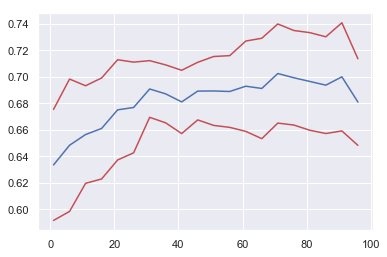

In [14]:
# Buscamos gráficamente el valor ópitmo para n_neighbors
plt.plot(df_scores['n_neighbours'],df_scores['limite_inferior'],color='r')
plt.plot(df_scores['n_neighbours'],df_scores['score_medio'],color='b')
plt.plot(df_scores['n_neighbours'],df_scores['limite_superior'],color='r');

## 4 - Matriz de confusión

Ahora que decidimos cuál es el mejor preprocesamiento y el mejor valor posible para los hiperparámetros podemos entrenar un modelo con estos criterios para obtener una matriz de confusión sobre datos no observados. 

### 4.1- Preprocesamos los datos
(repetimos los pasos de arriba sólo para que el proceso completo sea más claro)

In [15]:
# Matriz de features
# X = df[UNO]
X_train, X_test, y_train, y_test = train_test_split(X,y)

### 5.2- Split train-test

Ya sabiendo cuál es el mejor modelo, quiero obtener una matriz de confusión. Hacemos un nuevo split train-test porque siempre queremos evaluar dónde predice bien y dónde se equivoca el modelo **sobre datos no observados**.
Utilizo el mejor parámetro elegido que es n_neighbors = 71

In [16]:
# Elegimos el modelo óptimo que nos había indicado cross validation
model = KNeighborsClassifier(n_neighbors=71)
# Lo ajustamos sobre datos de entrenamiento
model.fit(X_train,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=71, p=2,
           weights='uniform')

In [17]:
# Lo utilizamos para predecir en test
y_pred = model.predict(X_test)

In [18]:
# Elaboramos la matriz de confusión:
confusion_matrix(y_test, y_pred)

array([[ 795,  454],
       [ 207, 1053]], dtype=int64)

1 : Transaccionó  |  0: No Transaccionó


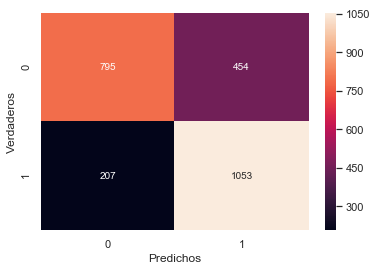

In [19]:
print('1 : Transaccionó  |  0: No Transaccionó')
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d')
plt.ylabel('Verdaderos')
plt.xlabel('Predichos');

In [20]:
target_names = ['No Transaccionó','transaccionó']

print(classification_report(y_test, y_pred, target_names = target_names))

                 precision    recall  f1-score   support

No Transaccionó       0.79      0.64      0.71      1249
   transaccionó       0.70      0.84      0.76      1260

      micro avg       0.74      0.74      0.74      2509
      macro avg       0.75      0.74      0.73      2509
   weighted avg       0.75      0.74      0.73      2509



**Usando GridSearch**

Con Knn uso la misma lista de valores que había generado para este caso. El GridSearch me sirve para tunear los hiperparámetros.

In [21]:
knn = KNeighborsClassifier()

`GridSearchCV` exige que la grilla de hiperparámetros a explorar sea un diccionario (o lista de diccionarios) con los nombres de los hiperparámetros y la lista de los posibles valores.

Instanciamos el método `GridSearchCV`:

In [22]:
from sklearn.model_selection import GridSearchCV
param_grid = dict(n_neighbors=k_range)

#muestro los parámetros
print(param_grid)

{'n_neighbors': [1, 6, 11, 16, 21, 26, 31, 36, 41, 46, 51, 56, 61, 66, 71, 76, 81, 86, 91, 96]}


### 2.1 Agregando otros parámetros para tunear


Vamos a agregar el parámetro binario de `weights` del algoritmo `KNeighborsClassifier`, que determina si algunos vecinos tendrán mayor ponderación que otros a la hora de clasificar. Mientras que el valor `uniform` asigna a todas las observaciones el mismo peso, el valor `distance` indica que el peso es inversamente proporcional a la distancia entre observaciones.

In [23]:
weight_options = ['uniform', 'distance']

Entonces, ahora el tunning se realizará iterando y alternando `weights` y `k`.

In [24]:
param_grid = dict(n_neighbors=k_range, weights=weight_options)
print(param_grid)

{'n_neighbors': [1, 6, 11, 16, 21, 26, 31, 36, 41, 46, 51, 56, 61, 66, 71, 76, 81, 86, 91, 96], 'weights': ['uniform', 'distance']}


Ajustamos los modelos:

In [25]:
grid = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')
grid.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_neighbors': [1, 6, 11, 16, 21, 26, 31, 36, 41, 46, 51, 56, 61, 66, 71, 76, 81, 86, 91, 96], 'weights': ['uniform', 'distance']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

Escogemos el mejor modelo:

In [26]:
grid.best_estimator_, grid.best_score_, grid.best_params_

(KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
            metric_params=None, n_jobs=None, n_neighbors=26, p=2,
            weights='uniform'),
 0.7394712368805633,
 {'n_neighbors': 26, 'weights': 'uniform'})

## 3. Usamos los mejores parámetros para correr las predicciones

In [27]:
knn = KNeighborsClassifier(n_neighbors=82, weights='uniform')
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

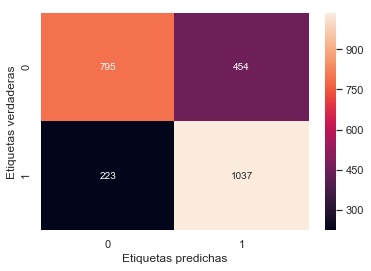

In [28]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True,  fmt='d')
plt.ylabel('Etiquetas verdaderas')
plt.xlabel('Etiquetas predichas');

In [29]:
print(classification_report(y_test, y_pred, target_names = target_names))

                 precision    recall  f1-score   support

No Transaccionó       0.78      0.64      0.70      1249
   transaccionó       0.70      0.82      0.75      1260

      micro avg       0.73      0.73      0.73      2509
      macro avg       0.74      0.73      0.73      2509
   weighted avg       0.74      0.73      0.73      2509



## Regresión Logística
Importamos las librerias correspondientes

In [30]:
from sklearn import linear_model
from sklearn.metrics import accuracy_score
from sklearn import model_selection
import warnings
warnings.filterwarnings('ignore')


Como nombramos al inicio queremos predecir si el usuario realizó una transacción monetaria o no.
En función de las características seteadas.

In [31]:
#Set de características
#X = df[UNO]

In [32]:
#Columna a predecir
#y =  df['CONTRATOTRANSACCIONMONETARIA']

***Creo el modelo***

Vamos a evaluar un modelo usando validación cruzada. La idea es estimar el test error usando validación cruzada en lugar de la partición clásica entre test y train.

1. Utilizo kflod y cross validation
2. Utilizo un set de validación del 20%

In [33]:
#Creo el modelo
model = linear_model.LogisticRegression()

In [34]:
#Genero el set de entrenamiento, test y validacion

#validation_size = 0.20
#seed = 7
#X_train, X_validation, y_train, y_test = model_selection.train_test_split(X, y, test_size=validation_size, random_state=seed)
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y)

In [35]:
#Armo con kflod la croos validation

name='Logistic Regression'
#kfold = model_selection.KFold(n_splits=10, random_state=seed)
kfold = model_selection.KFold(n_splits=10)
cv_results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy')
msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
print(msg)

Logistic Regression: 0.746513 (0.007970)


Muestro el mejor modelo

In [36]:
model.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [37]:
predictions = model.predict(X_test)
print(accuracy_score(y_test, predictions))

0.7437225986448784


## Reporte de Resultados

Armo la matriz de confusión y su gráfico correspondiente

In [38]:
print(confusion_matrix(y_test, predictions))

[[867 386]
 [257 999]]


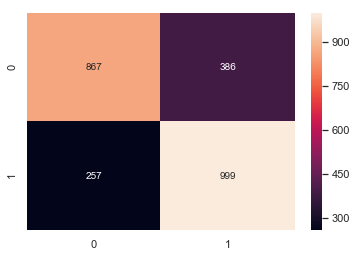

In [39]:
sns.heatmap(confusion_matrix(y_test, predictions), annot=True,fmt='d')

In [40]:
print(classification_report(y_test, predictions, target_names = target_names))

                 precision    recall  f1-score   support

No Transaccionó       0.77      0.69      0.73      1253
   transaccionó       0.72      0.80      0.76      1256

      micro avg       0.74      0.74      0.74      2509
      macro avg       0.75      0.74      0.74      2509
   weighted avg       0.75      0.74      0.74      2509



**Ahora pruebo con GridSearch**

In [41]:
#Genero el dict con los parámetros
logit_range = np.linspace(0.0001,1,100)

penalty_options = ['l1','l2']

logit_parametros = dict(C =  logit_range, penalty = penalty_options)


In [42]:
logit = linear_model.LogisticRegression()

grid = GridSearchCV(logit,logit_parametros,cv=5,scoring='accuracy')

grid.fit(X_train,y_train)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': array([1.000e-04, 1.020e-02, ..., 9.899e-01, 1.000e+00]), 'penalty': ['l1', 'l2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [43]:
#mejor modelo
grid.best_estimator_, grid.best_score_, grid.best_params_

(LogisticRegression(C=0.091, class_weight=None, dual=False, fit_intercept=True,
           intercept_scaling=1, max_iter=100, multi_class='warn',
           n_jobs=None, penalty='l1', random_state=None, solver='warn',
           tol=0.0001, verbose=0, warm_start=False),
 0.7483725255745981,
 {'C': 0.091, 'penalty': 'l1'})

In [44]:
logit_best = linear_model.LogisticRegression(C=0.1112, penalty="l2")

logit_best.fit(X_train, y_train)

predictions = logit_best.predict(X_test)

print(accuracy_score(y_test, predictions))



0.7421283379832603


## Reporte de Resultados

Armo la matriz de confusión y su gráfico correspondiente

In [45]:
print(confusion_matrix(y_test, predictions))

[[ 816  437]
 [ 210 1046]]


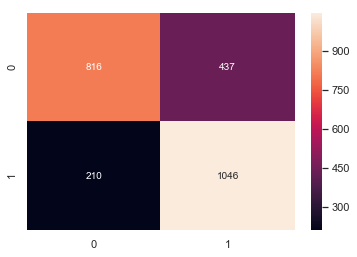

In [46]:
sns.heatmap(confusion_matrix(y_test, predictions), annot=True,fmt='d')

In [47]:
print(classification_report(y_test, predictions, target_names = target_names))

                 precision    recall  f1-score   support

No Transaccionó       0.80      0.65      0.72      1253
   transaccionó       0.71      0.83      0.76      1256

      micro avg       0.74      0.74      0.74      2509
      macro avg       0.75      0.74      0.74      2509
   weighted avg       0.75      0.74      0.74      2509



## Arboles

Pruebo el modelo con arboles y comparo

In [48]:
#cargo las librerias
from IPython.display import Image
from sklearn.tree import export_graphviz
import pydotplus
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier

In [49]:
#instancio el arbol
dt = DecisionTreeClassifier(max_depth = 3, min_samples_split = 2, random_state = 11)
dt.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=11,
            splitter='best')

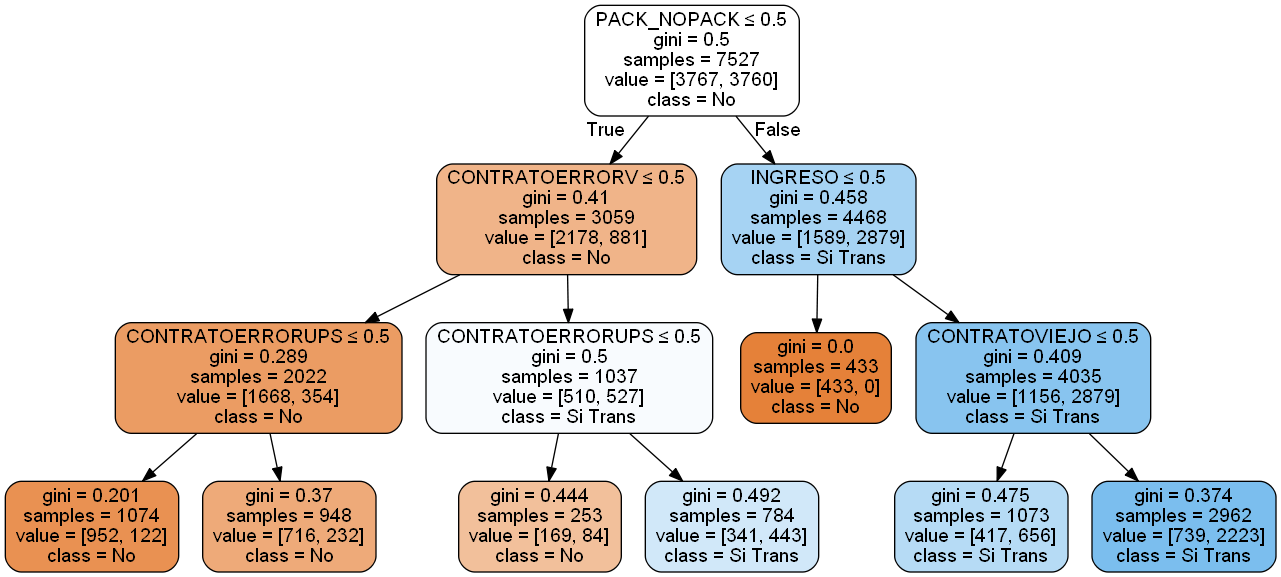

In [50]:
##Grafico para ver lo que me da

dot_data = export_graphviz(dt, out_file=None,  
                feature_names=X.columns,  
                class_names = ['No', 'Si Trans'],
                filled=True, rounded=True,
                proportion=False,
                max_depth = 5,
                special_characters=True)  

graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())


In [51]:
# veo lo que me da el arbol
y_pred = dt.predict(X_test)


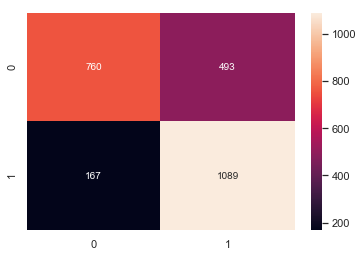

In [53]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True,fmt='d')

In [52]:
# Reporte de resultados
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.82      0.61      0.70      1253
           1       0.69      0.87      0.77      1256

   micro avg       0.74      0.74      0.74      2509
   macro avg       0.75      0.74      0.73      2509
weighted avg       0.75      0.74      0.73      2509



### Conclusión

De todos los modelos analizados que el mejor es el arbol clasificador. Para la busqueda que realizamos que es mejorar la sensibilidad/recall del modelo.